last updated 11 03 24

This notebook is to get the run times for each model on the highets and lowest Resolutions; to estimate an average run time.IG DICITONARY!



In [1]:
#!pip install ipython

In [2]:
# imports
import torch

import torch.nn as nn
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

#from torch.Utils.data import DataLoader
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np
import cv2

from torchvision.models import vgg16
from functions import import_imagedata, ImageProcessor, label_oh_tf, IDSWDataSetLoader2
from fns4wandb import set_lossfn
#from architectures import sevennet, smallnet1, smallnet2, smallnet3
from architectures import PrintLayer
from loop_fns import loop#, loop_batch, test_loop_batch
from plotting import learning_curve, accuracy_curve, plot_confusion

from datetime import date
from tqdm import tqdm
import pprint
import collections
from IPython.display import clear_output
import time

import csv
import json
import pickle
import os

import wandb

#import torch.Utils.data.DataLoader as DataLoader

In [3]:
#p = torch.cuda.memory_summary(device, abbreviated=False)
#Pp = pprint.PrettyPrinter(indent=4)
#Pp.pprint(p)

In [4]:
# file paths
_save_location = r'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/vgg16/'

data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

gitHASH = 'test'

In [5]:
wandb.login()


wandb: Currently logged in as: naughticalnonsence (antvis). Use `wandb login --relogin` to force relogin


True

In [6]:
#!pip install datetime

d = date.today()
#print(str(d), type(str(d)))

452 144 5/452 *100 = 1%
226 72 5/226 *100 = 2%
113 36 5/113 *100 = 4% -- 2/113 *100= 1.7% ~ 2%
57 18 (56.5,) 5/57 *100 = 8% -- 2/57 *100 = 3.5% ~ 4%. 1/57 = 1.75%
29 9 (28.5,) 5/29 *100 = 17% -- 2/29 *100 = 6.89 ~ 7% 1/28 = 3.57 ~ 4%
15 5 (14.5, 4.5)
8 3 (7.5,2.5)
4, 2 (, 1.5)

In [7]:
   

Pp = pprint.PrettyPrinter(indent=4)

def save2csv_nest_dict(nested_dict, file_name, save_location:str):
    # flattern nested dictionary
    flatterend_dict = {}
    for k,v in nested_dict.items():
        if isinstance(v, dict):
            for nested_key, nested_val in v.items():
                flatterend_dict[f"{k}_{nested_key}"] = nested_val
        else:
            flatterend_dict[k] =v
    
    columns = list(flatterend_dict.keys())
    
    with open(save_location+str(file_name)+'.csv', "a+", newline="") as f:
        # using dictwriter
        writer = csv.DictWriter(f, fieldnames=columns)
        # using writeheader function
        if f.tell() == 0:
            writer.writeheader()
        writer.writerow(flatterend_dict)
        f.close()

# check dictionary values for json and csv

def check_obj4np(obj):
    if isinstance(obj, dict):
        return {key: check_obj4np(value) for key, value in obj.items()}
    if isinstance(obj,list):
        return [check_obj4np(item) for item in obj]
    if isinstance(obj,Np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    else:
        return obj

# save to json
def save2josn_nested_dict(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    json_obj = json.dumps(nested_dict, indent=4)
    with open(save_location+str(file_name)+'.json', 'a+') as f:
        f.write(json_obj)
        f.close()

    
#save_location+str(file_name)+'.csv'
def save2csv(nested_dict, file_name, save_location:str):
    
    nested_dict = check_obj4np(nested_dict)
    
    columns = list(nested_dict.keys())
    path = os.path.join(save_location, file_name +".csv")
    try:
        with open(path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            # using dictwriter
            # using writeheader function
            if f.tell() == 0:
                writer.writeheader()
            writer.writerow(nested_dict)
            f.close()
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except ValueError:
              print("could not convert to string")
    except:
              print("unexpected error: ", sys.exc_info()[0])
        

def save2json(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    #print(nested_dict)
    #print(nested_dict.items())
    json_obj = json.dumps(nested_dict, indent=4)
    #print(json_obj)
    path = os.path.join(save_location, file_name+".json")
    #print(path)
    with open(path, 'w') as f:
        f.write(json_obj)
        
        


def read_in_json(file_path, file_name):
    path = os.path.join(file_path, 'file_name')
    try:
        with open(path, 'r') as f:
            #obj = f.read()
            dj = json.load(f, object_pairs_hook= collections.OrderedDict) #obj, 
            #print(dj)
    except Exception as e:
        print("Error decoding Json")
        print(e)


class Flattern(nn.Module):
    def __init__(self):
        super(Flattern, self).__init__()
    def forward(self, x):
        #print(x.shape)
        x = x.flatten()
        return x


def choose_model(model_name, lin_lay, dropout):

    if model_name == '4c3l':
        return smallnet1(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '3c2l':
        return smallnet2(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks = (3,5), dropout=dropout)
    elif model_name == '2c2l':
        return smallnet3(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '7c3l':
        return sevennet(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == 'vgg16':
        #model_vgg16 = vgg16(weights="IMAGENET1K_V1")
        #vgg_feats = model_vgg16.features
        #vgg_classifier = model_vgg16.classifier
        #vgg_classifier.pop(6)

        #vgg = nn.Sequential(
        #    vgg_feats,
        #    Flattern(),
        #    vgg_classifier,
        #    nn.Linear(4096,11), # cheanging the output layer
        #    nn.Softmax(dim=0),    (1x1032192 and 4096x4096)
        #    )

        class VGG16Smaller(nn.Module):
            def __init__(self, num_classes=11):
                super(VGG16Smaller, self).__init__()
                self.layer1 = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU())
                self.layer2 = nn.Sequential(
                    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(), 
                    nn.MaxPool2d(kernel_size = 2, stride = 2))
                self.layer3 = nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU())
                self.layer4 = nn.Sequential(
                    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size = 2, stride = 2))
                self.layer5 = nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU())
                self.layer6 = nn.Sequential(
                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU())
                self.layer7 = nn.Sequential(
                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size = 2, stride = 2))
                self.fc = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(64512, 4096), # 1032192 and 4096x4096)
                    nn.ReLU())
                self.fc1 = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(4096, 4096),
                    nn.ReLU())
                self.fc2= nn.Sequential(
                    nn.Linear(4096, num_classes))
                
            def forward(self, x):
                out = self.layer1(x)
                out = self.layer2(out)
                out = self.layer3(out)
                out = self.layer4(out)
                out = self.layer5(out)
                out = self.layer6(out)
                out = self.layer7(out)
                PrintLayer()
                out = out.reshape(out.size(0), -1)
                out = out.flatten(start_dim=1)
                PrintLayer()
                out = self.fc(out)
                out = self.fc1(out)
                out = self.fc2(out)
                out = F.log_softmax(out, dim=1) 
                return out
        vgg = VGG16Smaller()
        return vgg
    else:
        print('Model Name Not Recognised')




def check_model_sizes_bits(model):
    bits = 32
    mods = list(model.modules())
    sizes = []
    total_bits = 0
    
    for i in range(1,len(mods)):
        m = mods[i]
        p = list(m.parameters())
        for j in range(len(p)):
            sizes.append(np.array(p[j].size()))
    
    for i in range(len(sizes)):
        s = sizes[i]
        bitz = np.prod(np.array(s))*bits
        total_bits += bitz
    total_bytes = total_bits/8
    total_megabytes = total_bytes/1e+6
    total_gigabytes = total_megabytes/1000
    print(total_bits, 'bits    ', total_bytes, "bytes    ", total_megabytes, "MegaBytes    ", total_gigabytes,"GigaBytes") # 148480


def ptrblk_fin_mod_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    size_all_gb = size_all_mb/953.674
    print('model size: {:.3f}MB'.format(size_all_mb))
    print('model size: {:.3f}GB'.format(size_all_gb))




In [8]:
# dictionaries

date = date.today()

model_card_vgg = {'name': 'vgg', 'model': 'vgg16',
                  'f_lin_lay':[1032192,#4096,  # (1x229376 and 25088x4096)  1x229376 and 25088x4096) 1x229376 and 25088x4096)
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                            ],
                 'idx': 0,
                 'dropout':0.2}


model_card_7c3l = {'name': '7c3l', 'model': '7c3l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[248832,    # 452 144 # p5
                            59904,      # 226 72 # p5
                            11264,      # 113 36 # p2
                            1536,       # 57 18 # p1
                            172032,           # 29 9
                            172032,          # 15 5
                            172032,         # 8 3
                              ], 
                   'idx': 1,
                  'dropout':0.2}



model_card_4c3l = {'name': '4c3l', 'model': '4c3l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[539904,    # 452 144 # p5
                             141056,    # 226 72 # p5
                             304640,     # 113 36 # p2
                             9984,      # 57 18 # p1
                             2304,      # 29 9
                             512,       # 15 5
                             256],      # 8 3
                  'idx': 2,
                  'dropout':0.2}      

model_card_3c2l = {'name': '3c2l', 'model': '3c2l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[1069888,    # 452 144 # p5
                             274688,     #226 72 # p5
                             68096,      # 113 36 # p2
                             17280,      # 57 18 # p1
                             3840,       # 29 9
                             960,        # 15 5
                             256],
                  'idx': 3,
                  'dropout':0.2}       # 8 3

model_card_2c2l = {'name': '2c2l', 'model': '2c2l', 'channels': 3, 'Ks': (3,5),
                  'f_lin_lay':[16883712,#33767424,    # 452 144 # p5 # (1x33767424 and 1055232x100) (1x5276160 and 15828480x100) 1x33767424 and 5276160x100)
                             267264,     #226 72 # p5
                             64512,      # 113 36 # p2
                             15552,      # 57 18 # p1
                             3072,       # 29 9
                             640,        # 15 5
                             128],
                  'idx': 4,
                  'dropout':0.1}       # 8 3

resolution_card_452144 = {'resolution':[452,144], 'padding':5, 'index':0}
resolution_card_22672 = {'resolution':[226,72], 'padding':5, 'index':1}
resolution_card_11336 = {'resolution':[113,36], 'padding':2, 'index':2}
resolution_card_5715 = {'resolution':[57,18], 'padding':1, 'index':3}

resolution_card_299 = {'resolution':[29,9], 'padding':0, 'index':4} # 
resolution_card_155 = {'resolution':[15,5], 'padding':0, 'index':5}
resolution_card_83 = {'resolution':[8,3], 'padding':0, 'index':6}



resolution_cards = [ resolution_card_22672, resolution_card_452144, resolution_card_22672, resolution_card_11336, resolution_card_5715,
                    resolution_card_299, resolution_card_155, resolution_card_83]#]#
#resolution_cards = [resolution_card_11336]

#learning_rate_cards = [5e-5, 6e-5, 8e-5]
#learning_rate_cards = [8.21592E-05, 6.62E-05, 6.01E-05, 5.97E-05]
learning_rate_cards=  [0.0001]#, 6e-5, 7e-5, 8e-5]
#wd_cards = [4e-5, 5e-5, 3.00E-05, 2.00E-05]
wd_cards =[0]
scheduler_cards = [0]#, 0.1, 0.2]

seeds = [8]#,2,3] # 4, 5,6

#model_cards =[model_card_vgg, model_card_7c3l, model_card_4c3l, model_card_3c2l, model_card_2c2l]
model_cards =[model_card_vgg]

loss_fn_cards = ['MSE'] #,'CrossEntropy' 
                        
config = dict({'parameters': 'parameters for big loop run'})
config.update({'model_cards':model_cards})
config.update({'resolution_cards':resolution_cards})
config.update({'learning_rate_cards':learning_rate_cards})
config.update({'wd_cards':wd_cards})
config.update({'scheduler_cards':scheduler_cards})
config.update({'seeds':seeds})
config.update({'loss_fn_cards': loss_fn_cards})


#print(model_card_vgg)
#print('')
#Pp.pprint(Config) # dictionary of dictionaries of lists and lists of dictionaries

In [9]:

def train_val_batch(model, train, val, save_dict, lr, loss_fn, epochs,optimizer, scheduler_value, device): #train_dl, val_dl, 
    print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    model.train()

    t_loss_list = []
    v_loss_list = []
    t_predict_list = []
    v_predict_list = []
    t_accuracy_list = []
    v_accuracy_list = []
    t_label_list = []
    v_label_list = []
    #labels = []
    
    
    total_epochs = 0
    for epoch in tqdm(range(epochs)):
    
        print('Training...')
        print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        #!nvidia-smi
            
        """
 model, X, Y, loss_fn, device, size, pad, num_classes, model_name, av_lum,colour= 'colour', optimizer =None, scheduler= None, train =True
 """
            
        t_loss, train_prediction, train_targets, t_correct, model, optimizer = loop_batch(model, train, loss_fn, device, optimizer =optimizer, scheduler= scheduler_value, train =True) #, scheduler =scheduler
            
        t_loss_list.append(t_loss)
        t_predict_list.append(train_prediction)
        wandb.log({'t_loss':t_loss})
    
        train_acc = (t_correct/len(train)*100)
        print('train accuracy: ', train_acc )
        t_accuracy_list.append(train_acc)
        wandb.log({'train_acc':train_acc})
    
        
            
        print('validating...')
        
        v_loss, val_prediction, val_targets, val_correct= loop_batch(model, val, loss_fn, device, optimizer =None, scheduler= None, train =False)
        #
        print('post val')
        #!nvidia-smi
        #scheduler.step()
        v_loss_list.append(v_loss)
        v_predict_list.append(val_prediction)
        wandb.log({'v_loss':v_loss})
        #wandb.log({'v_predict_list':val_prediction})
        #wandb.log({'y_val':list(y_val)})
        val_acc = (val_correct/len(val)*100)
        v_accuracy_list.append(val_acc)
        print('validation accuracy: ', val_acc )
        wandb.log({'val_acc':val_acc})
    
        total_epochs += 1
        
    save_dict['Current_Epoch'] = epochs
    save_dict['training_samples'] = len(train)
    save_dict['validation_samples'] = len(val)
    
    save_dict['t_accuracy_list'] = t_accuracy_list 
    save_dict['v_accuracy_list'] = v_accuracy_list  #
            
    #model = best_model
    save_dict['t_loss_list'] = t_loss_list
    save_dict['v_loss_list'] = v_loss_list
    
    save_dict['t_labels'] = train_targets
    save_dict['v_labels'] = val_targets
    
    save_dict['t_predict_list'] = t_predict_list 
    save_dict['v_predict_list'] = v_predict_list  #
    
    return model, save_dict

def loop_batch(model, data, loss_fn, device, optimizer =None, scheduler= None, train =True):	# Train and Val loops. Default is train
    #for t, l in data:
    # print("loop_batch ",type(t), type(l))
    # break
    print("loopbatch 1 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    model = model
    total_samples = len(data)
    if train:
        model.train()
        #lr_ls = []
    else:
        model.eval()

    predict_list = []
    total_count = 0
    num_correct = 0
    current_loss = 0
    labels =[]
    #print(model_name)
    #print("loopbatch 2 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    #for x_batch,y_batch  in data:
    for i, batch in enumerate(data,0):
        #print("loop_batch_1 \n",type(tense), tense.shape,"\n", type(label), label.shape)
        #print("loopbatch 3 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        x_batch, y_batch = batch
        #print("loopbatch 4 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        
        #print(x_batch[0])
        #print(y_batch[0])
        #print("x_batch shape ",x_batch.shape)
        
        #print(type(tense), type(label))
       
        prediction = model.forward(x_batch)
        #print("loopbatch 5 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        #label = label.unsqueeze(1)
        #prediction = prediction.unsqueeze(1)
        #print("pred shape ",prediction.shape)
        #print("lab / y_batch shape ",y_batch.shape)
        loss = loss_fn(prediction, y_batch)
        
        #print("loopbatch 6 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
       
        #print("loopbatch 9 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        if train:
            optimizer.zero_grad()
            #print("loopbatch 10 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
            loss.backward()
            #print("loopbatch 11 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
            optimizer.step()
            #print("loopbatch 12 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        [predict_list.append(pred.argmax()) for pred in prediction]#.argmax())
        labels.append(y_batch)
        #print("loopbatch 7 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

        #if prediction.argmax() == y_batch.argmax():
        #    num_correct +=1

        #print(prediction.argmax(), y_batch.argmax())
        #print(prediction.shape, y_batch.shape)
        #print("loopbatch 8 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

        total_count+=1
        current_loss += loss.item()
        
    if scheduler:
        scheduler.step()
    #print("loopbatch 13 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
    #!nvidia-smi

    if train:
        return current_loss, predict_list, y_batch, num_correct, model, optimizer #, lr_ls
    else:
        return current_loss, predict_list, y_batch, num_correct


def test_loop(model, model_name, X, Y, res, pad, save_dict, loss_fn, device, av_lum, num_classes=11):
    model = model.eval()
    predict_list = []
    current_loss = 0
    total_count =0
    num_correct = 0
    correct = 0
    colour ='colour'
    size =  res

    with torch.no_grad():
        print('Testing...') 
        for idx, img in enumerate(X):

            #image pre processing
            prepro = ImageProcessor(device)
            if model_name == 'vgg16':
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True) #[29, 9], 15, 5, [8,3]
            elif (model_name == '7c3l' and size == [29, 9]) or (model_name == '7c3l' and size == [15, 5]) or (model_name == '7c3l' and size ==[8, 3]):
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True)
            else:
                tense = prepro.colour_size_tense(img, colour, size,av_lum,  pad)

            print("tense 1 ",tense.shape)
            tense = tense.unsqueeze(dim=0)
            print("tense 2 ",tense.shape)

            # send through model
            prediction = model.forward(tense)
            label = label_oh_tf(Y[idx], num_classes).to(device)

            print(label.shape)
            label = label.unsqueeze(dim=0)
            print(label.shape)
            loss = loss_fn(prediction, label)

            if prediction.argmax()==label.argmax():
                num_correct +=1
            total_count +=1
            correct +=(prediction.argmax()==label.argmax()).sum().item()

            predict_list.append(prediction.argmax())

        acc = num_correct/total_count
        accuracy = 100*(acc)
        
        
        
        current_loss += loss.item()
        
    return accuracy, predict_list, Y, current_loss

## model, data, loss_fn, device, optimizer =None, scheduler= None, train =True
def test_loop_batch(model,data, loss_fn, device):
    model = model.eval()
    predict_list = []
    label_list = []
    total_count =0
    num_correct = 0
    correct = 0
    

    with torch.no_grad():
        for i, batch in enumerate(data,0):
            #tense = tense.to(device)
            tense, label = batch
            label = label.to(device)
            
            prediction = model.forward(tense.to(device))
            #print('p', prediction.shape, 'l ', label.shape)
            #label = label_oh_tf(Y[idx], device, num_classes)
            for i in range(len(label)-1):
                if label[i].argmax() == prediction[i].argmax():
                    num_correct +=1
            predict_list.append(prediction)
            label_list.append(label)
            # label[i] == predictoin[i]. 
    
            #if prediction.argmax()==label.argmax():
            #    num_correct +=1
            total_count +=1
            #correct +=(prediction.argmax()==label.argmax()).sum().item()
    
        acc = num_correct/total_count
        accuracy = 100*(acc)

        print(accuracy)
    
        #X = list(X)
        #log_test_score(acc, accuracy, X) # test_acc,test_predict_list, y_test, test_loss 
        return accuracy, predict_list, label_list



def get_data(random_seed):
    file_path =  data_path
    #print(file_path)
    img_len = len(os.listdir(file_path))
    
    x, y = import_imagedata(file_path)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)

    return x_train, y_train, x_val, y_val, x_test, y_test


    
def get_lin_lay(model_card, resolution):
    if resolution == [452, 144]:
        lin_lay = model_card['f_lin_lay'][0]
    elif resolution == [226, 72]:
        lin_lay = model_card['f_lin_lay'][1]
    elif resolution == [113, 36]:
        lin_lay = model_card['f_lin_lay'][2]
    elif resolution == [57, 18]:
        lin_lay = model_card['f_lin_lay'][3]
    elif resolution == [29, 9]:
        lin_lay = model_card['f_lin_lay'][4]
    elif resolution == [15, 5]:
        lin_lay = model_card['f_lin_lay'][5]
    elif resolution == [8, 3]:
        lin_lay = model_card['f_lin_lay'][6]
    else:
        print("PARAMETER NOT FOUND: \n f_lin_lay FROM MODEL CARD")
    return lin_lay


In [10]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"


def _go(config=None):
    #!nvidia-smi
    
    print("Max allocated memory (GB):", torch.cuda.max_memory_allocated() / 1024 ** 3)
    
    if len(gitHASH) <1:
        print("YOU FORGET THE GIT HASH")
        return
    else:
        #print('Git Hash registered')
        pass
        
    with wandb.init(config=config, project=f"test Big Loop batching", notes="First logging test of big loop batcing . limitied data",):
        config = wandb.config
        start = time.process_time()
            
        for model_idx, model_card in enumerate(config['model_cards']):
            #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                    
            model_name = model_card['model']
            model_index = model_card['idx']
            dropout = model_card['dropout'] 
            for res_idx, resolution_card in enumerate(config['resolution_cards']):
                #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
            
                resolution = resolution_card['resolution']
                pad = resolution_card['padding']
                lin_lay = get_lin_lay(model_card, resolution)
            
                for lr_idx, lr in enumerate(config['learning_rate_cards']):
                    for wd_idx, wd_card in enumerate(wd_cards):
                        for sched_idx, scheduler_value in enumerate(config['scheduler_cards']):
                            for seed_idx, seed in enumerate(config['seeds']):
                                seed = seed
                                for lossfn_idx, lossfn in enumerate(config['loss_fn_cards']):
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    #print("in for loops")
                                    #!nvidia-smi
                                    torch.cuda.empty_cache()
                                    #!nvidia-smi
                                    

                                    #print('Model: ', str(model_name), f" idx: {model_idx} / {len(Config.model_cards)}")
                                    #print(Config.model_cards, len(Config.model_cards), typec(onfig.model_cards))
                                    
                                    print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    print('resolution: ', str(resolution), f" idx: {res_idx} / {len(config['resolution_cards'])}")
                                    print('learning rate: ', str(lr), f" idx: {lr_idx} / {len(config['learning_rate_cards'])}")
                                    print('weight decay: ', str(wd_card), f" idx: {wd_idx} / {len(config['wd_cards'])}")
                                    print('scheduler: ', str(scheduler_value), f" idx: {sched_idx} / {len(config['scheduler_cards'])}")
                                    print('seed: ', str(seed), f" idx: {seed_idx} / {len(config['seeds'])}")
                                    print('loss function: ', str(lossfn), f" idx: {lossfn_idx} / {len(config['loss_fn_cards'])}")
                                    run_start_time = time.process_time()
                                    print('start time ',run_start_time)
                                    #print("after model param prints")
                                    #!nvidia-smi
   
                                    print(time.process_time() - start)
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    
        
                                    epochs = 2 #40

                                    IP = ImageProcessor(device)
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

                                    print(f"Total epochs: {epochs}")
                                    #print("before wandb log")
                                    #!nvidia-smi
                                    wandb.log({'gitHash':gitHASH})
                                    wandb.log({'Epochs': epochs})
                                    # set save dictionary
                                    save_dict = {'Run' : f"{model_name}_{date}",
                                                 'Current_Epoch': 0,
                                                 'save_location' : _save_location}
                                    #print("before model is set")
                                    #print("main 1 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    
                                    # set model
                                    model = choose_model(model_name, lin_lay, dropout).to(device)
                                    #!nvidia-smi
                                    #check_model_sizes_bits(model)
                                    #ptrblk_fin_mod_size(model)
                                    #print('after model is set')
                                    #print("main 2Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    #print(model, '\n', type(Config))
                                    # get image data
                                    #print("after model is set. before data got")
                                    #!nvidia-smi
                                    #print('before dataloader')
                                    #print("main 3 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    
                                    x_train, y_train, x_val, y_val, x_test, y_test = get_data(seed)
                                    av_lum = IP.new_luminance(x_train)
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    
                                    train_ds = IDSWDataSetLoader2(x_train, y_train, resolution,pad,av_lum,model_name, device)# av_lum, res,pad,
                                    train = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True) #, num_workers=2
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    #for i,j in train:
                                    # print("_go: ",type(i), type(j))
                                    # break
                                    
                                    test_ds = IDSWDataSetLoader2(x_test, y_test, resolution,pad,av_lum,model_name, device)
                                    test = DataLoader(test_ds, batch_size=16, shuffle=True, drop_last=True) #, num_workers=2
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    val_ds = IDSWDataSetLoader2(x_val, y_val, resolution,pad,av_lum,model_name, device)
                                    val = DataLoader(val_ds, batch_size=16, shuffle=True, drop_last=True) #, num_workers=2

                                    #print('after dataloader')
                                    #print("main 4 Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    
                                    #print("post dataloader")
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    #!nvidia-smi
                                    # set loss function
                                    loss_fn = set_lossfn(lossfn)
                                    
                                    # set optimizer
                                    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
                   
                                    #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_value, last_epoch=-1) 

                                    
                                    wandb.watch(model, loss_fn, log='all', log_freq=2, idx = model_index)
                                    #print("before train val batch")
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
                                    #!nvidia-smi
                                    model, save_dict=  train_val_batch(model, train,val, save_dict, lr, loss_fn,epochs, optimizer, scheduler_value, device)
                                    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3) # model, model_name, X, Y, res, pad, save_dict, loss_fn, device, av_lum,
                                    #test Y, 
                                    test_acc,test_predict_list, y_test = test_loop_batch(model,test, loss_fn, device) #model, model_name, X, Y, res, pad, loss_fn, device, num_classes=11
                                    
                                    #print(test_predict_list)
                                    print(' \n train Acc: ', save_dict['t_accuracy_list'][-1])
                                    print(' \n val Acc: ', save_dict['v_accuracy_list'][-1])
                                    print(' \n test Acc: ', test_acc)
                                    
                                    save_dict.update({'test_acc': test_acc})
                                    save_dict.update({'test_predict': test_predict_list})
                                    save_dict.update({'test_labels': list(y_test)})
                                    #save_dict.update({'test_loss':test_loss})

                                    loop_run_name = f"{save_dict['Run']}_{resolution}_{lr}_{scheduler_value}_{seed}_{lossfn}"


                                    learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=loop_run_name)
                                    accuracy_curve(save_dict['t_accuracy_list'], save_dict['v_accuracy_list'],save_location=save_dict['save_location'],run_name=loop_run_name)
                                    test_predict_list=[pred.cpu() for pred in test_predict_list]
                                    plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = loop_run_name,save_location =save_dict['save_location'])
                                    
                                    wandb.log({'test_acc': test_acc})
                                    wandb.log({'test_predict': test_predict_list})
                                    wandb.log({'test_labels': list(y_test)})
                                    #saving
                                    diction = {}
                                    d = date.today()
                                    d=str(d)
                                    diction.update({'Date':d})
                                    diction.update({'gitHASH':str(gitHASH)})
                                    diction.update({'model_name': str(model_name)})
                                    diction.update({'loss_fn': str(lossfn)})
                                    diction.update({'lr': str(lr)})
                                    diction.update({'wd': str(wd_card)})
                                    diction.update({'scheduler value': str(scheduler_value)})
                                    diction.update({'seed': str(seed)})
                                    diction.update({'resolution': str(resolution)})
                                    diction.update({'pad': int(pad)})
                                    diction.update({'lin_lay': int(lin_lay)})
                                    diction.update({'run time': (time.process_time() - run_start_time)})
                                    diction.update(save_dict)
                                    
                                    save_location = save_dict['save_location']
                                    title = save_dict['Run']
                                    save2json(diction, title, save_location)
                                    save2csv(diction, title, save_location)
        
                                    diction['model.state_dict'] = model.state_dict() #to('cpu').
        
                                    with open(f"{save_location}{loop_run_name}.pkl", 'Wb+') as f:
                                        pickle.dump(diction, f)
                                    
                                    #clear_output()
                                    
                                    print(f' \n END {model_name} {resolution} Run Time: ',time.process_time() - run_start_time)
                                    torch.cuda.empty_cache()
        print('Final Run time: ',time.process_time() - start)

Max allocated memory (GB): 0.0


Model:  vgg16  idx: 0 / 1
resolution:  [226, 72]  idx: 0 / 8
learning rate:  0.0001  idx: 0 / 1
weight decay:  0  idx: 0 / 1
scheduler:  0  idx: 0 / 1
seed:  8  idx: 0 / 1
loss function:  MSE  idx: 0 / 1
start time  11.359856471
0.001153601999998699
Total epochs: 2
Current allocated memory (GB): 0.0


  0%|                                                                    | 0/2 [00:00<?, ?it/s]

Training...
Current allocated memory (GB): 0.0
loopbatch 1 Current allocated memory (GB): 0.0
train accuracy:  0.0
validating...
loopbatch 1 Current allocated memory (GB): 0.0


 50%|██████████████████████████████                              | 1/2 [00:11<00:11, 11.82s/it]

post val
validation accuracy:  0.0
Training...
Current allocated memory (GB): 0.0
loopbatch 1 Current allocated memory (GB): 0.0
train accuracy:  0.0
validating...
loopbatch 1 Current allocated memory (GB): 0.0


100%|████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.71s/it]

post val
validation accuracy:  0.0


279.6875
 
 train Acc:  0.0
 
 val Acc:  0.0
 
 test Acc:  279.6875


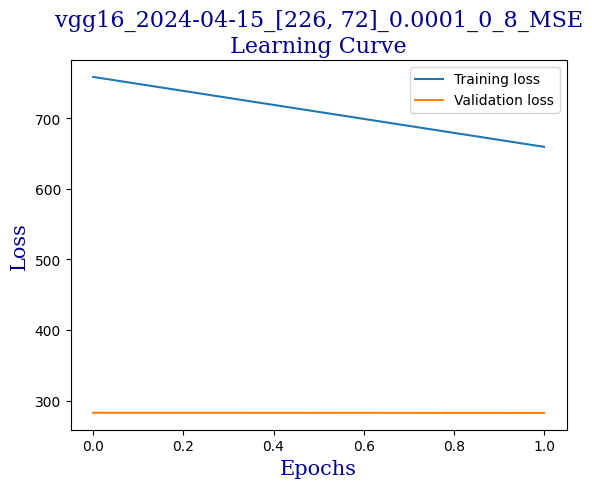

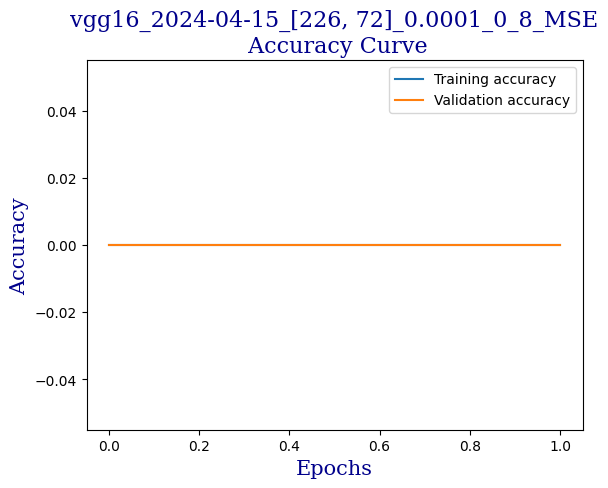

Traceback (most recent call last):
  File "/tmp/ipykernel_53444/3244493497.py", line 153, in _go
    plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = loop_run_name,save_location =save_dict['save_location'])
  File "/its/home/nn268/antvis/antvis/optics/plotting.py", line 22, in plot_confusion
    predict_list = [int(t.numpy()) for t in predictions]
  File "/its/home/nn268/antvis/antvis/optics/plotting.py", line 22, in <listcomp>
    predict_list = [int(t.numpy()) for t in predictions]
TypeError: only length-1 arrays can be converted to Python scalars


Epochs,▁
t_loss,█▁
train_acc,▁▁
v_loss,█▁
val_acc,▁▁
Epochs,2
gitHash,test
t_loss,659.63039
train_acc,0.0
v_loss,282.4568
val_acc,0.0


TypeError: only length-1 arrays can be converted to Python scalars

In [11]:
_go(config)

In [ ]:
# 12.58 GiB. GPU 0 has a total capacty of 23.65 GiB of which 8.04 GiB is free
23.65-8.04


pred torch.Size([11])

lab  torch.Size([5, 11])